<a href="https://colab.research.google.com/github/gshartnett/introAI/blob/main/homeworks/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Modern AI - HW 3
**Student's Name**: Swaptik Chowdhury 
Instructor: Gavin Hartnett  
PRGS, Winter Quarter 2022  

This HW is worth 12.5% of your grade. Complete the assignment by making a local copy of this Colab Notebook and filling in the responses in your local copy. If you do not know how to typset math in LaTeX, feel free to email me a scanned piece of paper with your work instead. 

## Problem 1: CIFAR-100 Classification

Train a CNN model on the CIFAR-100 classification task. Feel free to use the Week 4 Notebook as a guide (and recall that this notebook both shows how to download the CIFAR data and how to build and train a CNN on MNIST). Evaluate the test set accuracy after training it.

One of the main goals for this exercise is to get you to work through how each layer of a CNN affects the shape/dimensionality of the data. The MNIST code will have to be modified to account for the fact that the CIFAR images are 32x32 and are also in color (c=3, as opposed to c=1). I suspect this will be the hardest part of this problem. I did not cover this in class, but you should be able to figure it out using the PyTorch docs pages and by making liberal use of inserting helpful debugging `print(x.shape)` statements throughout the `forward(self, x)` method. 

To help set you on the right path, this is how the input/output dimensions are related for some operations you will need to use:

**[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)**  
- function call `Conv2d(Cin, Cout, KernelSize, Stride=1)`
- Input shape: (N, Cin, Hin, Win)  
- Output shape: (N, Cout, Hout, Wout)
    - where Cout is a free parameter, and 
    - Hout = Hin - (KernelSize - Stride)  
    - Wout = Win - (KernelSize - Stride)

**[MaxPool2d](https://pytorch.org/docs/1.9.1/generated/torch.nn.MaxPool2d.html)**  
`MaxPool2d(2)` cuts the image size by half. 

**Flatten**  
At some point you will need to flatten the data to go from 4 dimensions to 2, i.e.
- Input shape: (N, Cin, Hin, Win)
- Output shape: (N, Cin * Hin * Win)

In [1]:
## imports

## numpy
import numpy as np
#from numpy.random import default_rng
#rng = default_rng(123)
np.random.seed(123)

## other useful data analysis libraries
import pandas as pd
from sklearn import neighbors

## plotting
from matplotlib.colors import ListedColormap
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


# For CIFAR Data
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [ ]:
# Defining Neural Network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        # input channel (1 for BW & 3 for RGB/color), output channel which is kind of random/treat as hyperparameter, kernel size or filter = single digit for same height and width, stride
        # read it as 3 channel gets somehow split into 32 channels by using a 3 by 3 filter. Not shown here, for every convlution layer and using stride as one, the output size is Initial size
        # (32 pixels for this case)- Kernel (3) - 1 (stride). So before the convolution, the size was 32 pixel x 32 pixel x 3 (for images, the channels like RGB is treated a sthird dimension.)
        # (think of it as a cube.) After convultion, the new size of the image or cube is 30 pixel (reduced from convultion) x 30 pixel x 64 channeld (imagine 3 channels being split into 64).
        # also note that in this case each image is being considered a scube. So after convolution, 1 image will be split into 32
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # At this stage, each output from 1st convultion layer is being split into 64. So total size is 32*64
        self.dropout1 = nn.Dropout(0.25) # Dropout doesnot remove the node/filter/channels from calculation. From a matric prespective, its weight is just set to 0. 
        # Thus, Dropout doesnot impact shape
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12544, 128) # this 12544 is 14 *14*64. Check when this full layer is being called. Its happening after two convultion layer and a max pools. So 32 pixel is reduced
        # to 30 pixel at first convolution to 28 after second convolution and then halfed (because we cahose maxpool2) by maxpool to 14. So for flattening we just multiply : 14x14x64. Or look at error and replace the value
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        ## convolutional block (no max pool - not sure why)
        x = self.conv1(x)
        x = F.relu(x)
        #print('shape of hidden layer 1: ', x.shape)

        ## convolutional block
        x = self.conv2(x)
        x = F.relu(x)
        #print('shape of hidden layer 2 before maxpool: ', x.shape)
        x = F.max_pool2d(x, 2) # every maxpool halfs the pixel size
        #print('shape of hidden layer 2: ', x.shape)
        x = self.dropout1(x)

        ## fully connected layer 1
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        #print('shape of hidden layer 3: ', x.shape)

        ## fully connected layer 2
        x = self.fc2(x)
        #print('shape of hidden layer 4: ', x.shape)
        output = F.log_softmax(x, dim=1)
        #print('shape of output layer: ', output.shape)
        return output

In [ ]:
# CUDA Integration
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [ ]:
# Downloading the Data. Reference : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
import torchvision.transforms as transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


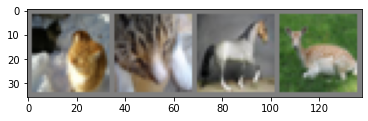

cat   cat   horse deer 


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# Define a Loss function and optimizer

import torch.optim as optim
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train the Network

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.008
[1,  4000] loss: 1.717
[1,  6000] loss: 1.583
[1,  8000] loss: 1.467
[1, 10000] loss: 1.430
[1, 12000] loss: 1.356
[2,  2000] loss: 1.258
[2,  4000] loss: 1.224
[2,  6000] loss: 1.207
[2,  8000] loss: 1.174
[2, 10000] loss: 1.169
[2, 12000] loss: 1.126
Finished Training


In [ ]:
# Saving the Model. Not Needed just exploring the functionalities https://pytorch.org/docs/stable/notes/serialization.html
#PATH = './cifar_net.pth'
#torch.save(net.state_dict(), PATH)

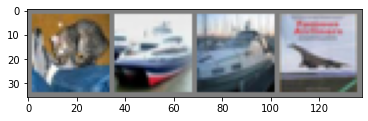

GroundTruth:  cat   ship  ship  plane


In [ ]:
# Testing the CNN model to confirm if CNN network has learnt anything
 # First let establish the ground truth
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
# Now lets see how the model perform on these images
outputs = net(images)
# The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  ship  ship  ship  plane


In [ ]:
# Now lets run the whole dataset using the model 

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [ ]:
# To check which model classes performed well

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.6 %
Accuracy for class: car   is 65.4 %
Accuracy for class: bird  is 36.9 %
Accuracy for class: cat   is 38.9 %
Accuracy for class: deer  is 53.8 %
Accuracy for class: dog   is 47.7 %
Accuracy for class: frog  is 86.5 %
Accuracy for class: horse is 63.8 %
Accuracy for class: ship  is 75.9 %
Accuracy for class: truck is 76.7 %


## Problem 2: Projected Gradient Descent (PGD)

There is a modification of gradient descent which allows the method to be applied to *constrained* optimization problems. For example, suppose that we wish to minimize a function $f(\boldsymbol{x})$ subject to the constraint that the point lie on the unit sphere, i.e., $x_1^2 + x_2^2 + x_3^2 = 1$. This can be accomplished through the use of a projection operator $P$, which takes a point in $\mathbb{R}^3$ (the original, unconstrained space) and and projects it to the nearest point on the sphere $S^2$ (the constraint surface). The update rule for projected gradient descent is:

$$ \boldsymbol{x}_{k+1} = P\left( \boldsymbol{x}_k - \alpha \nabla f(\boldsymbol{x}_k) \right) \,. $$

In other words, we carry out a standard gradient descent step, which may take us off the constraint surface, and to correct this we then project down to the nearest point on the surface. This approach, PGD, is widely used in the construction of so-called *adversarial examples*, which you may have heard of. These will be covered in the next course in the AI/Data Science sequence.

**Part A)**  
What is the projection operator here? In other words, given a point $\boldsymbol{x} = (x_1, x_2, x_3) \in \mathbb{R}^3$, what is the map to the nearest point on the sphere? Code this up in PyTorch. 

Hint: if the answer isn't immediately obvious, try drawing a picture. $P$ will end up being a pretty simple function. 

In [2]:
def orth_proj(t):
  norm = torch.linalg.norm (t)
  t_norm = t/norm
  return t_norm

#test it out on [1,1,1]

In [3]:
# Testing of orth_proj
y = [1,1,1]
b = torch.FloatTensor(y)
orth_proj(b)

tensor([0.5774, 0.5774, 0.5774])

The projection operator is orthogonal.

**Part B)**  
For this exercise, we will need a function to minimize. By Googling around, I found a cute one [here](https://www.juliahomotopycontinuation.org/examples/optimization/):

$$ f(\boldsymbol{x}) = 3 x_1^3 x_2 + x_2^2 x_3^2 - 2 x_1 x_2 - 4 x_1 x_3^3 \,. $$

Implement this function, again in PyTorch. 

In [13]:
def cutefunc(x):
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  return 3*x1**3*x2+x2**2*x3**2-2*x1*x2-x1*4*x3**3 

**Part C)**  
Implement projected gradient descent for the function $f$, subject to the constaint that the point lie on the sphere. Initialize with a randomly chosen point on the sphere, and use PyTorch's autodiff to compute the gradient.

Hints: 
- `x` will need to be a PyTorch tensor with `requires_grad=True`. 
- When performing the update step, we need to do so within a `torch.no_grad()` environment. This is because we are looping the result of the autodiff to then alter the inputs, which will then be used to once again compute a gradient, and so on. To help, I'll include a template for how your code should look:

```
def PGD_template():
    init x
    set requires_grad=True for x
    loop over a number of iterations
        compute the gradient
        with torch.no_grad():
            update x
        set requires_grad=True for x again
    return x, f(x)
```

In [19]:
from torch._C import dtype
torch.manual_seed(42)
x = torch.rand(3, requires_grad=True, dtype=torch.float)
iters = 100
lr = 0.001
def PGD(x):
  i = 0
  while i< iters:
    cute = cutefunc(x)
    #print(cute)
    cute.backward()
    with torch.no_grad():
      x = orth_proj(x-lr*x.grad)
    x.requires_grad_()
    i += 1
  return cute

In [20]:
PGD(x)

tensor(-0.4493, grad_fn=<SubBackward0>)

**Part D)**  
Carry out multiple runs of your PGD code, each with a different random initialization. What is the global minimum?

In [21]:
#comment out the print(cute) from code cell above before running this code cell
iters = 10
i = 0
mcute = []
while i< iters:
  x = torch.rand(3, requires_grad=True, dtype=torch.float) 
  mcute.append(PGD(x)) 
  i +=1
min_cute = min(mcute)  
print (min_cute)

tensor(-1.2058, grad_fn=<SubBackward0>)


**Part E)**  
This problem is simple enough that we can solve it many other ways. For example, we can solve it using regular gradient descent without constraints by imposing directly that $\boldsymbol{x}$ lie on the sphere, which can be accomplished via:

$$ x_1 = \sin\theta \cos\phi \,, \quad x_2 = \sin\theta \sin\phi \,, \quad x_3 = \cos\theta \,, \quad \text{where} \quad \theta \in [0, \pi], \quad \phi \in [0, 2\pi] \,.$$

Build a PyTorch implementation of the function $h(\theta, \phi) = f(x_1(\theta, \phi), x_2(\theta, \phi), x_3(\theta))$ and optimize it using regular gradient descent (i.e., drop the $P$ operation). Hopefully you get the same answer for the minimal value of $f$. Also, I hope this helps to impress you with the power of autodiff - working out $\nabla_x f$ doesn't seem too bad, but working out $\nabla_{\Omega} h$, where $\Omega = (\theta, \phi)$, would be much more tedious. 

In [27]:
def f(params):
  theta = params[0]
  phi = params[1]
  x1= torch.sin(torch.angle(theta))*torch.cos(torch.angle(phi))
  x2= torch.sin(torch.angle(theta))*torch.sin(torch.angle(phi))
  x3= torch.cos(torch.angle(theta))
  polar = 3*x1**3*x2+x2**2*x3**2-2*x1*x2-x1*4*x3**3 
  return polar

In [28]:
def rad2deg(rad):
    pi_on_180 = 0.017453292519943295
    return rad / pi_on_180

In [35]:
iters = 100 # No of runs
lr = 0.1
params = rad2deg(torch.FloatTensor(2).uniform_(to=2*np.pi)) # Initializing theta and phi as elements of tensor params. The angles are in degrees
if params[0]>180: # As per prompt, ensuring theta is <180
  params[0] = params[0]%180
params.requires_grad = True # Making Required grad true
print("The theta value is:", params[0]) # FOr checking the value of theta and phi 
print("The phi value is:", params[1])
def GD(params):
  i = 0
  while i< iters:
    polar_f = f(params)
    print(polar_f)
    polar_f.backward()
    with torch.no_grad():
      params -= lr*params.grad # Updating the params
    params.requires_grad_()
    i += 1
  return polar_f

The theta value is: tensor(123.2328, grad_fn=<SelectBackward0>)
The phi value is: tensor(228.3631, grad_fn=<SelectBackward0>)


In [36]:
GD(params)

tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<SubBackward0>)
tensor(0., grad_fn=<

tensor(0., grad_fn=<SubBackward0>)